Modeling the brusselator

In [96]:
import numpy as np
from scipy.fft import fftn, ifftn
%matplotlib inline

Brusselator:

$$\dot u = \triangle u +a - (b+1)u + u^2v$$
$$ \dot v = \triangle v + bu - u^2v$$
or in other words

$$\dot u = \triangle u f_u$$
$$ \dot v = \triangle v +f_v$$
This is in 2D. With random initial data. Do I need to worry about initial conditions? No!
I also want to be able to add a new function and a parameter

In [97]:
N = 256
dt = 0.05
fu = lambda a,b,u,v: a + (u**2)*v - (b+1)*u
fv = lambda a,b,u,v: b*u-(u**2)*v
L = 10*2*np.pi
NUM_STEPS = 1000
a = 1
b = 3
# D0 = 1 
# D1 = 0.1

D0=2.8
D1 = 22.4
# put only things I want to change
# don't want to change diffusion too much. At least for now.



In [98]:
def create_initial_array(num_of_nodes = N, ampl = 0.1):
    #return initial concentration of substance. Can be random, should be positive
    return np.random.rand(num_of_nodes,num_of_nodes) * ampl
# for now
def create_wavenumber_array(num_modes=N, L = L):
    # create array for wavenumbers in scipy format.
    num_modes = num_modes - num_modes%2 # make num of nodes even. Why?
    wavenum_array = np.zeros(num_modes)
    wavenum = 2*np.pi/L
    p1 = np.array([(wavenum * i) for i in range(int(num_modes/2))])
    
    p2 = np.array([wavenum * (-num_modes+n) for n in range(int(num_modes/2), num_modes)])
    wavenum_array = np.concatenate((p1,p2))
    return wavenum_array
def create_time_operator(wavenums, diffusion_coeff, timestep = dt):
    ## create a time evolution operator
    num_nodes = wavenums.size
    operator = np.empty((num_nodes,num_nodes))
    wavenums = wavenums**2
    # for i in range(num_nodes):
    #     for j in range(num_nodes):
    #         wavenumber = -(wavenums[i]**2+wavenums[j]**2)
    #         operator[i,j] = np.exp(timestep*diffusion_coeff*wavenumber)
    wavenums_sq = wavenums[:, np.newaxis]+wavenums
    operator = np.exp(-wavenums_sq*timestep*diffusion_coeff)
    
    return operator

In [99]:
# create_time_operator(create_wavenumber_array(5), D0)

In [100]:
def perform_simulation(a=a,b=b, timestep = dt, fu = fu, fv = fv, N = N, NUM_STEPS=NUM_STEPS):
    
    # initialize data
    initial_data_u = create_initial_array(N)
    initial_data_v = create_initial_array(N)
    wavenums = create_wavenumber_array(N, L=L)
    ## initialize operators
    operator_u = create_time_operator(wavenums, D0, timestep)
    operator_v = create_time_operator(wavenums, D1, timestep)
    
    ##initialize returned data
    time = np.empty(NUM_STEPS)
    time[0] = 0
    shape = time.shape+initial_data_u.shape
    conc_u = np.empty(shape)
    conc_v = np.empty(shape)
    conc_u[0] = initial_data_u
    conc_v[0] = initial_data_v

    ## begin calculations
    for i in range(NUM_STEPS-1):
        # initialize

        u = conc_u[i]
        v = conc_v[i]
        ## apply euler scheme
        nonlin_u = u + fu(a,b,u,v)*dt
        nonlin_v = v + fv(a,b,u,v)*dt
        ## use Fourier transform
        ## NOTES: I could combine u and v into complex array.
        fft_u = fftn(nonlin_u)
        fft_v = fftn(nonlin_v)

        ## perform timestep in fourier domain
        fft_u = fft_u * operator_u
        fft_v = fft_v * operator_v

        ## go back
        u = ifftn(fft_u).real
        v = ifftn(fft_v).real

        ## record the data
        time[i+1] = time[i] + timestep
        conc_u[i+1] = u
        conc_v[i+1] = v

    return time, conc_u, conc_v


In [101]:
def perform__trunc_simulation(a=a,b=b, L=L,timestep = dt, D0=D0, D1 = D1,fu = fu, fv = fv, N = N, NUM_STEPS=NUM_STEPS, savetimes = [0, NUM_STEPS//2, NUM_STEPS-2]):
    
    # initialize data
    initial_data_u = create_initial_array(N)
    initial_data_v = create_initial_array(N)
    wavenums = create_wavenumber_array(N, L=L)

    ## initialize operators
    operator_u = create_time_operator(wavenums, D0, timestep)
    operator_v = create_time_operator(wavenums, D1, timestep)
    
    ##initialize data
    u = initial_data_u
    v = initial_data_v

    ## initialize saved data
    # shape = savetimes.shape+initial_data_u.shape
    u_saved = []
    v_saved = []
    ## begin calculations
    for i in range(NUM_STEPS-1):
        ## checking progress
        progress = float(i/NUM_STEPS)
        print(f"Progress: {progress}", end='\r', flush=True)
        # print(f"{progress}")
        # initialize saving date
        if i in savetimes:
            u_saved.append(u)
            v_saved.append(v)
        ## apply euler scheme
        nonlin_u = u + fu(a,b,u,v)*dt
        nonlin_v = v + fv(a,b,u,v)*dt
        ## use Fourier transform
        ## NOTES: I could combine u and v into complex array.
        fft_u = fftn(nonlin_u)
        fft_v = fftn(nonlin_v)

        ## perform timestep in fourier domain
        fft_u = fft_u * operator_u
        fft_v = fft_v * operator_v

        ## go back
        u = ifftn(fft_u).real
        v = ifftn(fft_v).real
    return u_saved, v_saved, savetimes


In [102]:
# perform_simulation(NUM_STEPS= 10)

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
# Plot u(x,y) for different time points (2D)
## critical values
N = 200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3

data_u, data_v, savetimes = perform__trunc_simulation(N = N,L=L,a=b, b=b, D1 =D1, D0=D0, NUM_STEPS=NUM_STEPS)
xs = np.arange(0.0,L,L/N)
ys = np.arange(0.0,L,L/N)
print(f"time = {dt*NUM_STEPS}")
X,Y = np.meshgrid(xs,ys)

from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure(figsize=(9.0,3.5))
fig.suptitle(f"Simulation for a={a},b={b}", fontsize =16)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.pcolormesh(X, Y, data_u[0], shading='auto')
ax2.pcolormesh(X, Y, data_u[1], shading='auto')
ax3.pcolormesh(X, Y, data_u[2], shading='auto')
# ax4 = fig.add_subplot(234)
# ax5 = fig.add_subplot(235)
# ax6 = fig.add_subplot(236)

# ax4.pcolormesh(X, Y, data_v[0], shading='auto')
# ax5.pcolormesh(X, Y, data_v[1], shading='auto')
# ax6.pcolormesh(X, Y, data_v[2], shading='auto')

plt.show()

In [103]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

def simulate_and_plot(a=a,b=b,NUM_STEPS=NUM_STEPS,N=N, D0=D0, D1=D1, timestep = dt, L=L, name = "default.png", save = False):
    
    data_u, data_v, savetimes = perform__trunc_simulation(a=a,b=b,NUM_STEPS=NUM_STEPS,N=N, D0=D0, D1=D1, timestep = dt, L=L )
    xs = np.arange(0.0,L,L/N)
    ys = np.arange(0.0,L,L/N)
    # print(f"time = {dt*NUM_STEPS}")
    X,Y = np.meshgrid(xs,ys)

    from matplotlib import animation, rc
    from IPython.display import HTML

    fig = plt.figure(figsize=(9.0,3.5))
    fig.suptitle(f"Simulation for a={a},b={b},NUM_STEPS={NUM_STEPS},N={N}, D0={D0}, D1={D1}, timestep = {dt}, L={L}", fontsize =16)  
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)

    ax1.pcolormesh(X, Y, data_u[0], shading='auto')
    ax2.pcolormesh(X, Y, data_u[1], shading='auto')
    ax3.pcolormesh(X, Y, data_u[2], shading='auto')
    ax3.set_title(f"time={dt*NUM_STEPS}")

    def show_patterns(U, ax=None):
        ax.imshow(U, cmap=plt.cm.copper,
                interpolation='bilinear',
                extent=[-1, 1, -1, 1])
        ax.set_axis_off()
    U=data_u[2]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    show_patterns(U, ax=ax)
    if save == True:
        fig.savefig(name, bbox_inches='tight')
    plt.show()

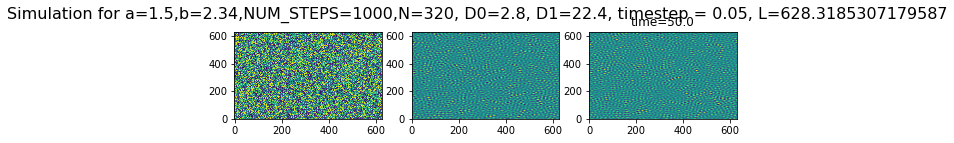

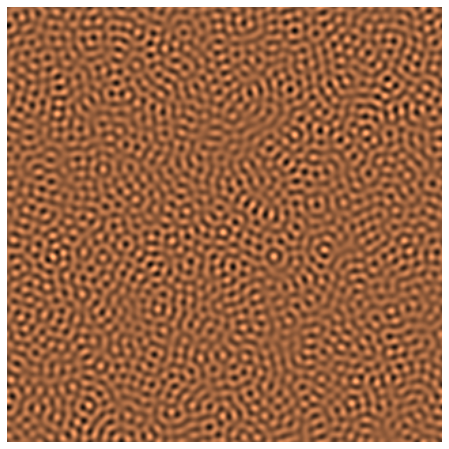

In [105]:
N = 320
L = 200*np.pi
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3
simulate_and_plot(a=a,b=b,NUM_STEPS=NUM_STEPS,N=N, D0=D0, D1=D1, timestep = dt, L=L, name = "successfull3.png")

I got nice results for

N = 256

L = 20\pi

a=1.5

b=2.34

D0=2.8

D1 = 22.4

dt = 0.05

NUM_STEPS = 10**3

FOR 

N = 1200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3
Also interesting at least at time NUM_STEPS/2


Also interesting
N = 200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3

What do I want from the simulation?
I want to be able to change the parameters rather easily. Or display a bunch of plots 
What parameters do I have?